This script contains some improvement from train.ipynb by default:
* much few layers, heads, and embedding dimension to reduce the model size
* dataloader v2 which uses a custom tokenizer (again to reduce model size)
* no positional embeddings (to reduce model complexity)
* weight tying (to reduce model size)


We implemented a few things here first and not before:
* validation losses
* increased the model size to be just below 30M parameters
* reduced the amount of data trained with to keep the training (wall) time consistent
* made graph more informative

This script contains a couple improvements from train2.ipynb:
* gradient accumulation is enabled
* the dataloader chunks from the start of an example up to the max_length or the endoftext token

This contains some changes from train3.ipynb:
* an accuracy metric has been implemented
* one cycle learning rate schedule is being used
* weight tying is disabled

This contains some improvements from train4.ipynb: just that the attention module used uses pytorchs implementation for sdpa. This also uses a text generation function to display the capabilities of the trained model.

This contains some changes over train5.ipynb. We use data loading hooks for setting up the train/validation data loaders. We also use the setup hook for setting up the gpt model. We also call compile on the gpt model before training. We also have some code for investigating memory leaks.

The train6 files were used to determine the cause of the memory leak which seems to have been using multiple workers which causes copy-on-reads to occur. setting num_wokers=0 in the dataloader resolves this issue.
See issue: https://github.com/pytorch/pytorch/issues/13246#issuecomment-905703662
blogpost: https://ppwwyyxx.com/blog/2022/Demystify-RAM-Usage-in-Multiprocess-DataLoader/

In [1]:
from tokenizers import Tokenizer

tokenizer = Tokenizer.from_file("./TinyStories_tokenizer.json")
vocab_size = tokenizer.get_vocab_size()

In [2]:
GPT_CONFIG_30M = {
    "vocab_size": vocab_size,
    "context_length": 512,
    "emb_dim": 512,
    "n_heads": 4,
    "n_layers": 4,
    "drop_rate": 0.0,
    "qkv_bias": False,
    "weight_tying": True,
    "no_pos_emb": True
}

In [3]:
GPT_CONFIG_30M_small_emb = {
    "vocab_size": vocab_size,
    "context_length": 512,
    "emb_dim": 256,
    "n_heads": 16,
    "n_layers": 18,
    "drop_rate": 0.0,
    "qkv_bias": False,
    "weight_tying": False,
    "no_pos_emb": False
}

In [4]:
GPT_CONFIG_60M = {
    "vocab_size": vocab_size,
    "context_length": 512,
    "emb_dim": 512,
    "n_heads": 8,
    "n_layers": 8,
    "drop_rate": 0.0,
    "qkv_bias": False,
    "weight_tying": False,
    "no_pos_emb": False # conflicts with sequence packing
}

In [ ]:
GPT_CONFIG_120M_DEEP = {
    "vocab_size": vocab_size,
    "context_length": 512,
    "emb_dim": 512,
    "n_heads": 64,
    "n_layers": 28,
    "drop_rate": 0.1,
    "qkv_bias": False,
    "weight_tying": False,
    "no_pos_emb": False # conflicts with sequence packing
}

In [ ]:
GPT_CONFIG_120M_SHALLOW = {
    "vocab_size": vocab_size,
    "context_length": 512,
    "emb_dim": 768,
    "n_heads": 64,
    "n_layers": 10,
    "drop_rate": 0.1,
    "qkv_bias": False,
    "weight_tying": False,
    "no_pos_emb": False # conflicts with sequence packing
}

In [ ]:
import socket
hostname = socket.gethostname().lower()
if "laptop" in hostname:
    GPT_CONFIG = GPT_CONFIG_30M
else:
    GPT_CONFIG = GPT_CONFIG_120M_FAST

In [7]:
import torch.nn as nn
import torch

torch.set_float32_matmul_precision('medium')

In [8]:
trainer_config = {
    "dataset_scale": 1,
    "batch_size": 32 if "laptop" in hostname else 16,
    "epochs": 1,
    "train_file_loc": "../data/TinyStories/TinyStoriesV2-GPT4-train.txt",
    "valid_file_loc": "../data/TinyStories/TinyStoriesV2-GPT4-valid.txt",
    "num_workers": 0,
    "max_lr": 1e-3,
    "compile": "laptop" not in hostname
}
trainer_config["grad_batches"] = 256 // trainer_config["batch_size"]

In [9]:
from components.gptmodel import GPTModel_v2
from torch.optim.lr_scheduler import OneCycleLR
from components.data import create_dataloader_v3
import lightning as L
from datasets import load_from_disk
from torch.utils.data import DataLoader


class LitGPTModel(L.LightningModule):
    def __init__(self, trainer_config, gpt_config):
        super().__init__()
        self.gpt_config = gpt_config
        self.trainer_config = trainer_config

        self.train_accuracy = []
        self.val_accuracy = []
        self.train_losses = []
        self.val_losses = []
        self.val_steps = []
        self.learning_rates = []
        self.batch_step = 0

    def _accuracy(self, output, expected):
        total_matching = (torch.argmax(output, dim=-1) == expected).sum().item()
        total_numel = expected.numel()
        return total_matching / total_numel

    def training_step(self, batch, batch_idx):
        self.batch_step += 1

        x, y = batch["input_ids"], batch["labels"]
        logits = self.model(x)

        accuracy = self._accuracy(logits, y)
        self.log("accuracy", accuracy, prog_bar=True, on_step=True, on_epoch=True)
        self.train_accuracy.append(accuracy)

        loss = self.loss(logits, y)
        self.log("loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        self.train_losses.append(loss.item())

        current_lr = self.optimizers().param_groups[0]["lr"]
        self.learning_rates.append(current_lr)

        return loss

    def validation_step(self, batch, batch_idx):
        self.val_steps.append(self.batch_step)
        x, y = batch["input_ids"], batch["labels"]

        logits = self.model(x)

        accuracy = self._accuracy(logits, y)
        self.log("val_accuracy", accuracy, prog_bar=True, on_step=True, on_epoch=True)
        self.val_accuracy.append(accuracy)

        loss = self.loss(logits, y)
        self.log("val_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        self.val_losses.append(loss.item())
        
        return loss

    def loss(self, output, expected):
        loss = nn.functional.cross_entropy(
            output.flatten(0, 1), expected.flatten()
        )
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(), lr=self.trainer_config["max_lr"], weight_decay=0.1
        )

        scheduler = OneCycleLR(
            optimizer,
            max_lr=self.trainer_config["max_lr"],
            total_steps=self.trainer.estimated_stepping_batches,
        )
        lr_scheduler_config = {
            "scheduler": scheduler,
            "interval": "step",
            "monitor": "loss"
        }

        return {
            "optimizer": optimizer,
            "lr_scheduler": lr_scheduler_config
        }

    def setup(self, stage):
        self.packed_dataset = load_from_disk("packed_dataset")
        self.packed_dataset.set_format('torch')

        self.model = GPTModel_v2(self.gpt_config)
        if self.trainer_config["compile"]:
            self.model = torch.compile(self.model, fullgraph=True)

        


    def train_dataloader(self):
        # use only 1/100 of the dataset for training
        # self.packed_dataset["train"] = self.packed_dataset["train"].shuffle(seed=42)
        # self.packed_dataset["train"] = self.packed_dataset["train"].select(
        #     range(int(len(self.packed_dataset["train"]) * self.trainer_config["dataset_scale"]))
        # )
        return DataLoader(self.packed_dataset["train"], batch_size=self.trainer_config["batch_size"], shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.packed_dataset["valid"], batch_size=self.trainer_config["batch_size"], shuffle=False)


/home/gebrial/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
litmodel = LitGPTModel(
    trainer_config,
    GPT_CONFIG
)

In [11]:
%%time

trainer = L.Trainer(
    max_epochs=trainer_config["epochs"],
    enable_progress_bar=True,
    accumulate_grad_batches=trainer_config["grad_batches"],
    logger=False,
    gradient_clip_val=1.0,
)
trainer.fit(model=litmodel)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/gebrial/miniforge3/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/gebrial/projects/llm-from-scratch/src/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
/home/gebrial/miniforge3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.

  | Name  | Type            | Params | Mode 
--------------------------------------------------
0 | model | Optimize

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/gebrial/miniforge3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 63878/63878 [4:29:59<00:00,  3.94it/s, accuracy_step=0.577, loss_step=1.720, val_accuracy_step=0.575, val_loss_step=1.730, val_accuracy_epoch=0.583, val_loss_epoch=1.680, accuracy_epoch=0.500, loss_epoch=2.270]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 63878/63878 [4:30:06<00:00,  3.94it/s, accuracy_step=0.577, loss_step=1.720, val_accuracy_step=0.575, val_loss_step=1.730, val_accuracy_epoch=0.583, val_loss_epoch=1.680, accuracy_epoch=0.500, loss_epoch=2.270]
CPU times: user 2h 52min 47s, sys: 1min 50s, total: 2h 54min 38s
Wall time: 4h 30min 11s


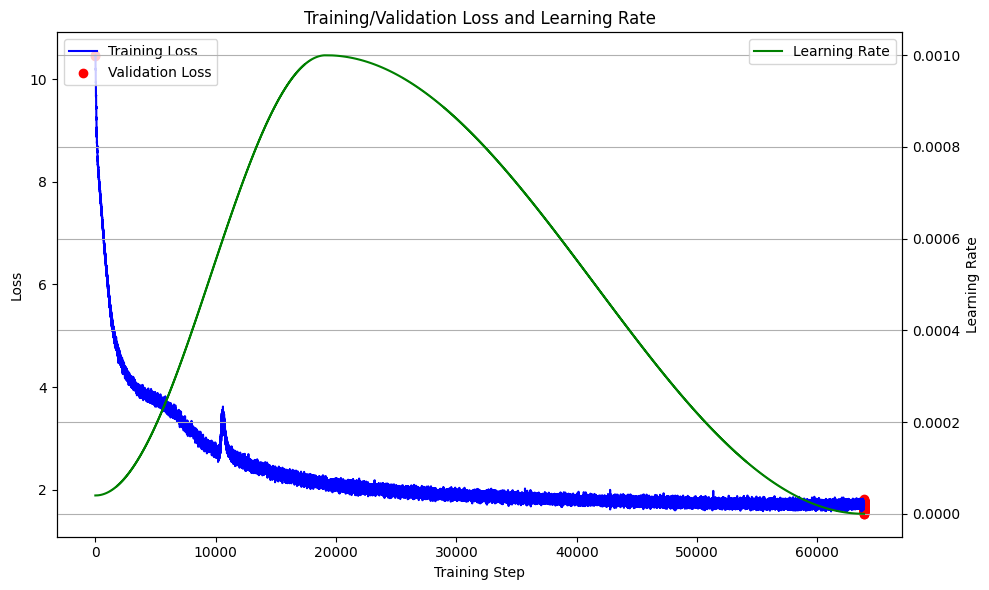

In [12]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(litmodel.train_losses, label="Training Loss", color="blue")
ax1.scatter(litmodel.val_steps, litmodel.val_losses, label="Validation Loss", color="red")
ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(litmodel.learning_rates, label="Learning Rate", color="green")
ax2.set_ylabel("Learning Rate")
ax2.legend(loc="upper right")

plt.title("Training/Validation Loss and Learning Rate")
plt.tight_layout()
plt.grid(True)
plt.show()

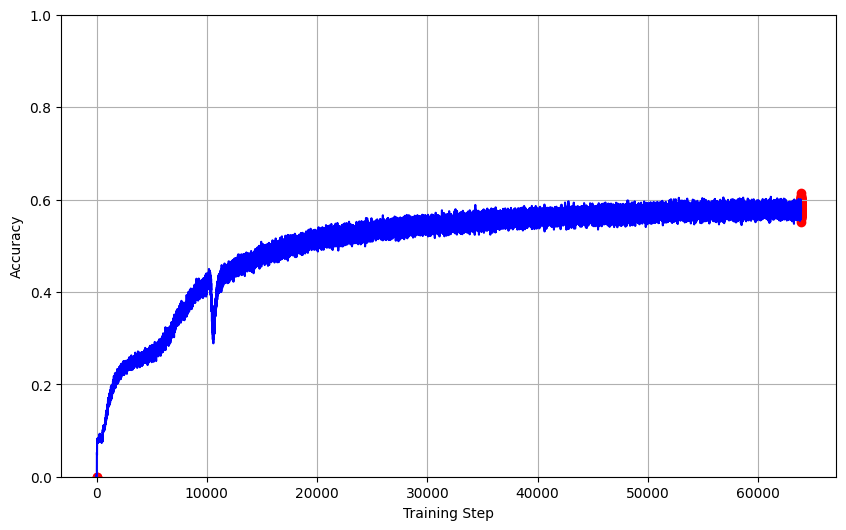

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(litmodel.train_accuracy, color="blue")
plt.scatter(litmodel.val_steps, litmodel.val_accuracy, color="red")
plt.xlabel("Training Step")
plt.ylabel("Accuracy")
plt.grid(True)
plt.ylim(0, 1)
plt.show()

In [14]:
from tokenizers import Tokenizer

In [15]:
tokenizer = Tokenizer.from_file("./TinyStories_tokenizer.json")

In [16]:
from tokenizers import decoders
tokenizer.decoder = decoders.WordPiece()

In [17]:
from components.generatetext import generate_text

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
litmodel.model.to(device)

OptimizedModule(
  (_orig_mod): GPTModel_v2(
    (tok_emb): Embedding(30002, 768)
    (pos_emb): Embedding(512, 768)
    (drop_emb): Dropout(p=0.1, inplace=False)
    (trf_blocks): Sequential(
      (0): TransformerBlock_v2(
        (att): MultiHeadAttention_v2(
          (W_query): Linear(in_features=768, out_features=768, bias=False)
          (W_key): Linear(in_features=768, out_features=768, bias=False)
          (W_value): Linear(in_features=768, out_features=768, bias=False)
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ff): FeedForward(
          (layers): Sequential(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Linear(in_features=3072, out_features=768, bias=True)
          )
        )
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (drop_shortcut

In [19]:
sum([p.numel() for p in litmodel.model.parameters() if p.requires_grad])

117333504

In [20]:
%%time
litmodel.eval()
starting_text = "Tom and Jane are friends. One day, Jane goes to Tom’s house. Tom has a big pot of soup. He wants to share it with Jane. “Jane, do you want some soup?” Tom asks. “Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is"
text = generate_text(litmodel.model, tokenizer, starting_text, 512, device, topk=3, temperature=1)
print("text: ", text)

text:  Tom and Jane are friends. One day, Jane goes to Tom ’ s house. Tom has a big pot of soup. He wants to share it with Jane. “ Jane, do you want some soup?” Tom asks. “ Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is bitter! It does not like to be in a soup anymore." Tom says sorry and says he is okay, and that he will not eat a bitter soup. Jane and the cat became best friends and played in their big yard together. And from then on the two were inseparable friends. One sunny afternoon she went out for the day. The little bird was so excited that she sang a beautiful melody. Suddenly, she heard her mum ' warning, " No more playing with the wire, it ' s too sharp!"
CPU times: user 9.96 s, sys: 1.99 s, total: 12 s
Wall time: 11.9 s


In [21]:
%%time
litmodel.eval()
starting_text = "Tom and Jane are friends. One day, Jane goes to Tom’s house. Tom has a big pot of soup. He wants to share it with Jane. “Jane, do you want some soup?” Tom asks. “Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is"
text = generate_text(litmodel.model, tokenizer, starting_text, 512, device, topk=3, temperature=1)
print("text: ", text)

text:  Tom and Jane are friends. One day, Jane goes to Tom ’ s house. Tom has a big pot of soup. He wants to share it with Jane. “ Jane, do you want some soup?” Tom asks. “ Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is hot and hard and bitter, not good. Tom does the soup.
CPU times: user 41.2 ms, sys: 14 μs, total: 41.2 ms
Wall time: 42.2 ms


In [22]:
%%time
litmodel.eval()
starting_text = "Tom and Jane are friends. One day, Jane goes to Tom’s house. Tom has a big pot of soup. He wants to share it with Jane. “Jane, do you want some soup?” Tom asks. “Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is"
text = generate_text(litmodel.model, tokenizer, starting_text, 512, device, topk=3, temperature=1)
print("text: ", text)

text:  Tom and Jane are friends. One day, Jane goes to Tom ’ s house. Tom has a big pot of soup. He wants to share it with Jane. “ Jane, do you want some soup?” Tom asks. “ Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is bitter! The dog was happy to see his friend. They all laughed and had fun. They were glad they had a fun day.
CPU times: user 56.8 ms, sys: 9.95 ms, total: 66.7 ms
Wall time: 69 ms


In [23]:
%%time
litmodel.eval()
starting_text = "Tom and Jane are friends. One day, Jane goes to Tom’s house. Tom has a big pot of soup. He wants to share it with Jane. “Jane, do you want some soup?” Tom asks. “Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is"
text = generate_text(litmodel.model, tokenizer, starting_text, 512, device, topk=3, temperature=1)
print("text: ", text)

text:  Tom and Jane are friends. One day, Jane goes to Tom ’ s house. Tom has a big pot of soup. He wants to share it with Jane. “ Jane, do you want some soup?” Tom asks. “ Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is hot. The hot soup burns her hand and her mouth and makes a face too much water. Tom is angry and tries again, but it does not help. He says to Lily : " Lily! You are a bad girl. You are mean and rude."
CPU times: user 111 ms, sys: 29.8 ms, total: 141 ms
Wall time: 147 ms
